In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.ar_model import AutoReg

## load Kyoto data

In [8]:
train = pd.read_csv('Kyoto_filled.csv')
train['doy'] = pd.to_datetime(train['DATE']).dt.dayofyear
print(train.shape)
train.head()

(25212, 16)


,location,lat,long,alt,year,bloom_date,bloom_doy,DATE,SNWD,PRCP,TAVG,TMAX,TMIN,Status,CDD,doy
0,kyoto,35.011983,135.676114,44.0,1953,1953-04-11,101.0,1953-02-01,NaN,0.4,0.6,4.9,-2.4,0.0,0.6,32
1,kyoto,35.011983,135.676114,44.0,1953,1953-04-11,101.0,1953-02-02,NaN,0.1,1.4,6.2,-3.5,0.0,2.0,33
2,kyoto,35.011983,135.676114,44.0,1953,1953-04-11,101.0,1953-02-03,NaN,0.0,2.1,7.4,-1.4,0.0,4.1,34
3,kyoto,35.011983,135.676114,44.0,1953,1953-04-11,101.0,1953-02-04,NaN,0.0,2.2,4.7,-1.4,0.0,6.3,35
4,kyoto,35.011983,135.676114,44.0,1953,1953-04-11,101.0,1953-02-05,NaN,0.0,2.7,8.4,0.4,0.0,9.0,36


In [9]:
train.describe()

,lat,long,alt,year,bloom_doy,SNWD,PRCP,TAVG,TMAX,TMIN,Status,CDD,doy
count,2.517100e+04,2.517100e+04,25171.0,25212.000000,25171.000000,0.0,25212.000000,25212.000000,25212.000000,25212.000000,25171.000000,25212.000000,25212.000000
mean,3.501198e+01,1.356761e+02,44.0,1987.099397,97.518295,NaN,4.662759,15.851877,20.801782,11.089024,0.736641,2613.237896,183.065286
std,1.615096e-11,6.508701e-11,0.0,19.926818,4.494840,NaN,12.282140,8.649944,8.928032,8.747054,0.440464,2043.370384,105.459208
min,3.501198e+01,1.356761e+02,44.0,1953.000000,85.000000,NaN,-13.745548,-3.000000,0.300000,-8.100000,0.000000,0.500000,1.000000
25%,3.501198e+01,1.356761e+02,44.0,1970.000000,95.000000,NaN,0.000000,7.900000,12.800000,2.900000,0.000000,558.575000,92.000000
50%,3.501198e+01,1.356761e+02,44.0,1987.000000,98.000000,NaN,0.000000,16.200000,21.200000,10.900000,1.000000,2290.134495,183.000000
75%,3.501198e+01,1.356761e+02,44.0,2004.000000,99.000000,NaN,4.333951,23.300000,28.200000,18.900000,1.000000,4675.066182,274.000000
max,3.501198e+01,1.356761e+02,44.0,2022.000000,110.000000,NaN,288.600000,33.350000,39.800000,28.841998,1.000000,6263.550000,366.000000


## $\log{\frac{P_t}{1-P_t}} = \beta_0 + \beta_1 t + \beta_2 \text{CDD}_t$

## $\text{CDD}_t = \sum_{i=1}^{t}T $

## plot lower and upper bound

In [10]:
# return the upper and lower bound near p_doy, from year start to year end
def p_doy_bound(start, end):
    
    # return upper, lower, beta0, beta1, beta2
    upper = np.zeros(end - start + 1)
    lower = np.zeros(end - start + 1)
    beta0 = np.zeros(end - start + 1)
    beta1 = np.zeros(end - start + 1)
    beta2 = np.zeros(end - start + 1)
    
    for year in range(start, end + 1):
        year_str = str(year)
        
        # create data column
        train_year = train[train['year'] == year][:180]
        features = ['doy', 'CDD']
        X = train_year[features]
        y = train_year.Status
        
        # fitting
        pred_model = linear_model.LogisticRegression(solver='lbfgs', max_iter=10000)
        pred_model.fit(X, y)
        beta = pred_model.coef_
        
        # get probability vs. doy function
        p_days = np.array(1 / (1 + np.exp(- np.matmul(X, beta.T) - pred_model.intercept_)))
        
        # get upper and lower bound
        day_bloom = int(np.array(train_year['bloom_doy'])[0])
        for i in range(0, 180):
            if p_days[i + 1, 0] > 0.5:
                lower[year - start] = p_days[i, 0]
                upper[year - start] = p_days[i + 1, 0]
                break
                
        beta0[year - start] = pred_model.intercept_[0]
        beta1[year - start] = beta[0, 0]
        beta2[year - start] = beta[0, 1]
        
    return upper, lower, beta0, beta1, beta2

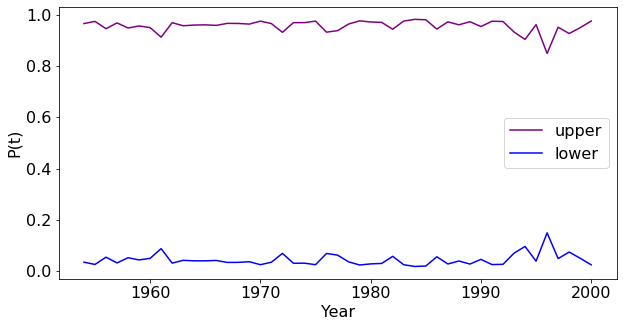

In [12]:
# plot the upper, lower bound vs. year
start = 1954
end = 2000
result = p_doy_bound(start, end)
# result[0]: upper
# result[1]: lower
# result[2]: beta0
# result[3]: beta1
# result[4]: beta2
x = np.arange(start, end + 1)

plt.figure(figsize=(10, 5))
plt.plot(x, result[0], color = 'purple', label = 'upper')
plt.plot(x, result[1], color = 'blue', label = 'lower')
plt.xlabel("Year", fontsize = 16)
plt.ylabel("P(t)", fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(fontsize = 16)
plt.show()

avg =  -316.25410615689646
std =  52.486250399417344


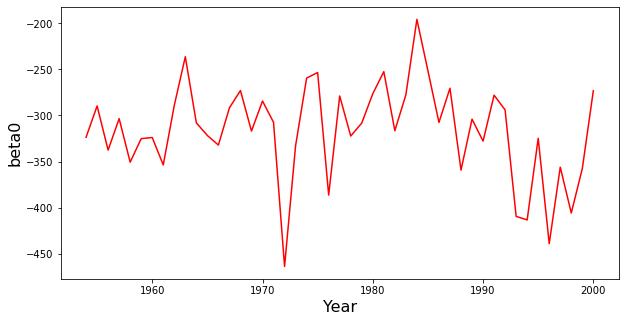

avg =  0.0450925046498774
std =  0.024094600430802422


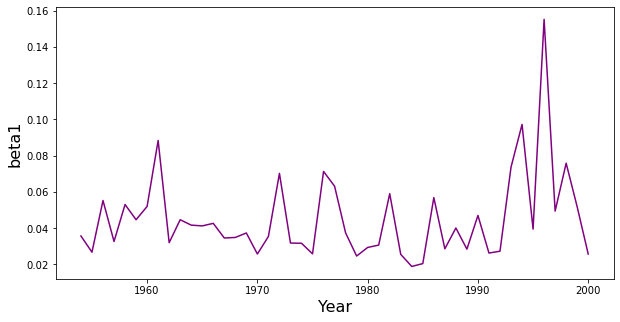

avg =  0.5069810643073905
std =  0.07120121355778362


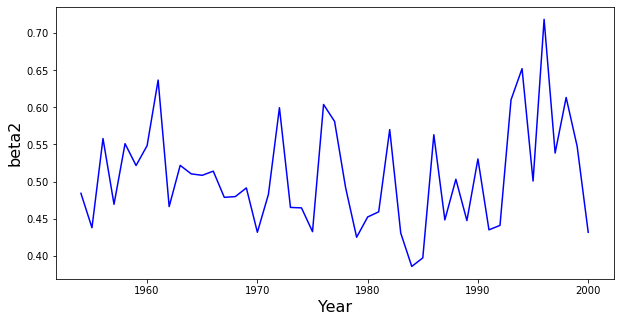

In [14]:
start = 1954
end = 2000
result = p_doy_bound(start, end)
# print("beta_0: ", result[2])
# print("beta_1: ", result[3])
# print("beta_2: ", result[4])
x = np.arange(start, end + 1)

plt.figure(figsize=(10, 5))
plt.plot(x, result[2], color = 'red')
print("avg = ", np.average(result[2]))
print("std = ", np.std(result[2]))
plt.xlabel("Year", fontsize = 16)
plt.ylabel("beta0", fontsize = 16)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(x, result[3], color = 'purple')
print("avg = ", np.average(result[3]))
print("std = ", np.std(result[3]))
plt.xlabel("Year", fontsize = 16)
plt.ylabel("beta1", fontsize = 16)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(x, result[4], color = 'blue')
print("avg = ", np.average(result[4]))
print("std = ", np.std(result[4]))
plt.xlabel("Year", fontsize = 16)
plt.ylabel("beta2", fontsize = 16)
plt.show()

## $\beta_i$ time series

### $\beta_0, \beta_1, \beta_2$ lag plot

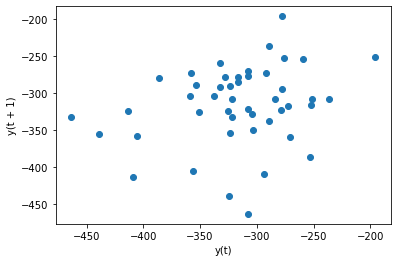

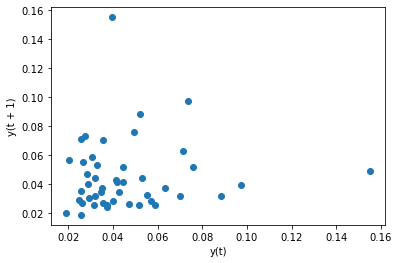

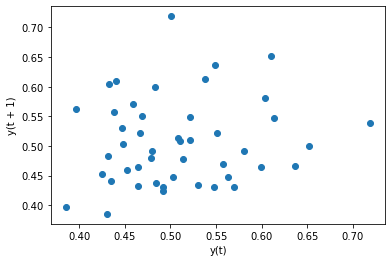

In [15]:
lag_plot(pd.Series(result[2]), lag=1)
plt.show()
lag_plot(pd.Series(result[3]), lag=1)
plt.show()
lag_plot(pd.Series(result[4]), lag=1)
plt.show()

### $\beta_0, \beta_1, \beta_2$ Autocorrection plot

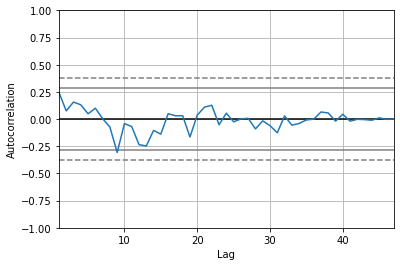

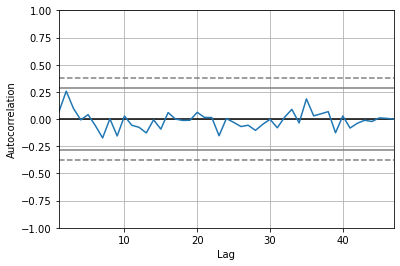

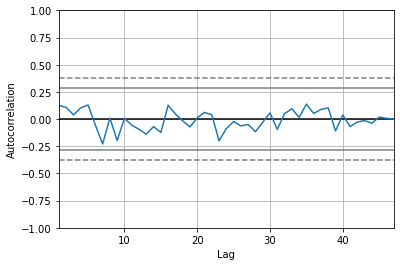

In [16]:
autocorrelation_plot(result[2])
plt.show()
autocorrelation_plot(result[3])
plt.show()
autocorrelation_plot(result[4])
plt.show()

## time series prediction - AutoReg

In [17]:
beta0_model = AutoReg(result[2], lags = 5).fit()
beta0_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                      y   No. Observations:                   47
Model:                     AutoReg(5)   Log Likelihood                -225.763
Method:               Conditional MLE   S.D. of innovations             52.267
Date:                Sat, 26 Feb 2022   AIC                              8.246
Time:                        22:06:45   BIC                              8.536
Sample:                             5   HQIC                             8.352
                                   47                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -182.9586     84.308     -2.170      0.030    -348.199     -17.718
y.L1           0.2478      0.157      1.580      0.114      -0.060       0.555
y.L2          -0.0431      0.159     -0.271      0.787      -0.355       0.269
y.L3           0.1500      0.162      0.926      0.354      -0.167       0.467
y.L4           0.0669      0.162      0.413      0.680      -0.251       0.385
y.L5          -0.0015      0.172     -0.009      0.993      -0.340       0.337
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.4434           -0.0000j            1.4434           -0.0000
AR.2           -0.2303           -1.7672j            1.7822           -0.2706
AR.3           -0.2303           +1.7672j            1.7822            0.2706
AR.4           -3.1098           -0.0000j            3.1098           -0.5000
AR.5           46.2636           -0.0000j           46.2636           -0.0000
-----------------------------------------------------------------------------
"""

## Compare the $\beta_i$

In [19]:
start = 1954
end = 2000
result_val = p_doy_bound(2001, 2021)

## $p$ value:
$\beta_0$: 9

$\beta_1$: 2

$\beta_2$: 13

In [20]:
result[2]

array([-323.71420722, -289.6457303 , -337.56065579, -303.4420661 ,
       -350.66137203, -325.13541208, -323.91820983, -353.67551417,
       -289.04436456, -236.21847292, -307.96407384, -321.71995628,
       -332.11044264, -291.70736576, -272.94839999, -316.89568902,
       -284.31171083, -307.41974467, -463.84163154, -332.81289346,
       -259.44175571, -253.38375244, -386.39185793, -278.83999609,
       -322.30720567, -308.16428079, -276.42064678, -252.4211227 ,
       -316.53894315, -277.59668759, -195.68499792, -251.47008709,
       -307.52113317, -270.43050902, -359.28427834, -304.00773233,
       -327.81364652, -277.9805892 , -293.99359495, -409.51124425,
       -413.33949874, -324.80552185, -439.11560018, -356.10773458,
       -405.82833654, -357.68467068, -273.10965216])

In [21]:
result_val[2]

array([-262.96476449, -310.12177135, -288.30154115, -296.40092412,
       -265.18391949, -314.52377407, -399.11155012, -315.53406568,
       -359.57293842, -311.64055411, -289.05577368, -255.07950806,
       -308.97081148, -378.54307552, -281.03928316, -350.96257848,
       -340.37520626, -318.99185505, -328.26786341, -392.38401132,
       -346.66911718])

In [22]:
result[3]

array([0.03564289, 0.02670293, 0.05522281, 0.03259359, 0.05301061,
       0.04461269, 0.051945  , 0.08836685, 0.03195152, 0.04460625,
       0.04162713, 0.04120929, 0.04260668, 0.0345141 , 0.03483201,
       0.03729025, 0.02568012, 0.03536057, 0.07018771, 0.03173875,
       0.03161954, 0.02579171, 0.07127117, 0.06312589, 0.03734628,
       0.02457417, 0.02930301, 0.03061444, 0.05898525, 0.02548605,
       0.01882015, 0.02039302, 0.05683038, 0.02856761, 0.04004319,
       0.02837718, 0.0469695 , 0.02621503, 0.02723778, 0.07362047,
       0.09722291, 0.03942904, 0.15522541, 0.04938157, 0.07581244,
       0.05172263, 0.02566012])

In [23]:
result_val[3]

array([0.02747136, 0.02970344, 0.03461175, 0.03532017, 0.02252294,
       0.04453916, 0.05146214, 0.04814576, 0.047563  , 0.03328781,
       0.03846181, 0.02525842, 0.04506637, 0.07305522, 0.02592668,
       0.03364315, 0.04132444, 0.05287124, 0.03265835, 0.04006207,
       0.04453173])

In [24]:
result[4]

array([0.4840526 , 0.43766987, 0.5579506 , 0.4692737 , 0.5510333 ,
       0.52156688, 0.54839889, 0.63683188, 0.46619446, 0.52177869,
       0.51030378, 0.5083547 , 0.51397247, 0.4786279 , 0.47964911,
       0.49133608, 0.4315236 , 0.4825846 , 0.59953188, 0.4650405 ,
       0.4644142 , 0.43233431, 0.60392389, 0.58109506, 0.49171831,
       0.42481917, 0.45214226, 0.4591032 , 0.5700498 , 0.43044187,
       0.38541805, 0.396989  , 0.563094  , 0.44820488, 0.50304895,
       0.44729394, 0.53039515, 0.43481487, 0.44079421, 0.61016873,
       0.65222811, 0.50062138, 0.71874618, 0.53841459, 0.61338141,
       0.54723991, 0.43153914])

In [25]:
result_val[4]

array([0.4420408 , 0.45434504, 0.47919311, 0.48261587, 0.4117117 ,
       0.52118163, 0.54568066, 0.53438173, 0.53258697, 0.47264296,
       0.49641918, 0.42907576, 0.52290621, 0.60624026, 0.43297459,
       0.47433723, 0.50828299, 0.54997882, 0.46970896, 0.50352737,
       0.52104493])

## Validation 2001 - 2000

In [42]:
beta0_model = AutoReg(result[2], lags = 1, trend='c').fit()
beta1_model = AutoReg(result[3], lags = 10, trend='c').fit()
beta2_model = AutoReg(result[4], lags = 7, trend='c').fit()
# validate the blooming doy
# return the predicted doy and the real doy
def predict_blooming_beta_ts(start, end):
    
    training_start = 1954
    
    predict = np.zeros(end - start + 1)
    real = np.zeros(end - start + 1)
    
    L_train = len(result[2])
    
    beta0_pre = beta0_model.predict(start-training_start, end-training_start, dynamic=False)
#     beta0_pre = np.array([np.median(result[2])] * (end - start + 1))
    beta1_pre = beta1_model.predict(start-training_start, end-training_start, dynamic=False)
    beta2_pre = beta2_model.predict(start-training_start, end-training_start, dynamic=False)
    
    for year in range(start, end + 1):
        year_str = str(year)
        
        # build the real doy array
        CU = np.average(train[train['year'] == year - 1][-71:]['TAVG'])
        train_year = train[train['year'] == year][:180]
        real[year - start] = int(np.array(train_year['bloom_doy'])[0])
        
        features = ['doy', 'CDD']
        X = train_year[features]
        y = train_year.Status
        
        # time series predict beta_i
        b = np.array([[beta1_pre[year - start], beta2_pre[year - start]]])
#         b0 = np.array([beta0_pre[year - start]])
        if CU < 9:
            b0 = np.array([beta0_pre[year - start] + 50])
#         elif CU > 9:
#             b0 = np.array([beta0_pre[year - start] - 40])
        else:
            b0 = np.array([beta0_pre[year - start]])
        
        p_days = np.array(1 / (1 + np.exp(- np.matmul(X, b.T) - b0)))
        
        for i in range(180):
            if p_days[i, 0] > 0.5:
                predict[year - start] = i + 1
                break
        
    return predict, real


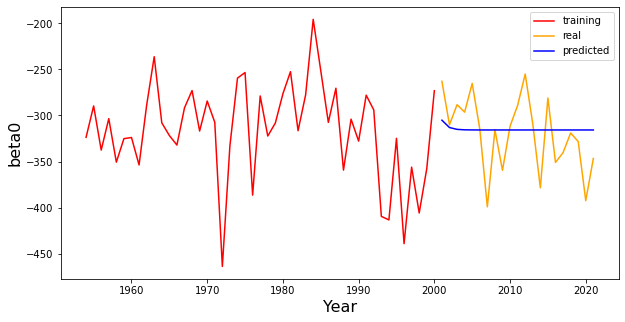

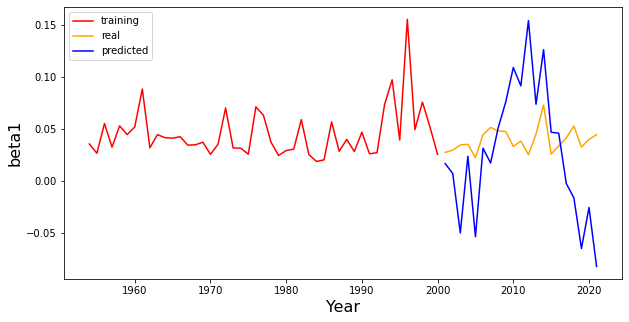

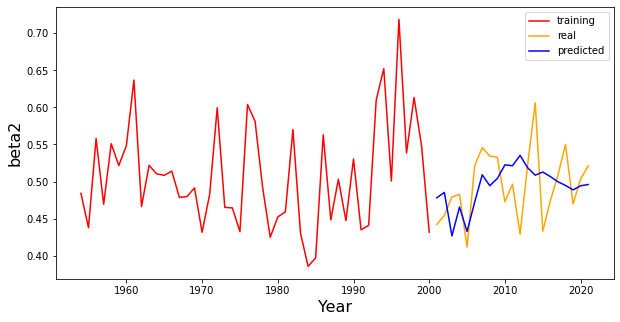

In [43]:
start = 1954
end = 2000
result_val = p_doy_bound(2001, 2021)
x = np.arange(start, end + 1)
x_v = np.arange(2001, 2021 + 1)
plt.figure(figsize=(10, 5))
plt.plot(x, result[2], color = 'red', label = 'training')
plt.plot(x_v, result_val[2], color = 'orange', label = 'real')
plt.plot(np.arange(2001, 2021 + 1), beta0_model.predict(2001-1954, 2021-1954, dynamic=False), 
         color = 'blue', label = 'predicted')
plt.xlabel("Year", fontsize = 16)
plt.ylabel("beta0", fontsize = 16)
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(x, result[3], color = 'red', label = 'training')
plt.plot(x_v, result_val[3], color = 'orange', label = 'real')
plt.plot(np.arange(2001, 2021 + 1), beta1_model.predict(2001-1954, 2021-1954, dynamic=False), 
         color = 'blue', label = 'predicted')
plt.xlabel("Year", fontsize = 16)
plt.ylabel("beta1", fontsize = 16)
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(x, result[4], color = 'red', label = 'training')
plt.plot(x_v, result_val[4], color = 'orange', label = 'real')
plt.plot(np.arange(2001, 2021 + 1), beta2_model.predict(2001-1954, 2021-1954, dynamic=False), 
         color = 'blue', label = 'predicted')
plt.xlabel("Year", fontsize = 16)
plt.ylabel("beta2", fontsize = 16)
plt.legend(loc='upper right')
plt.show()

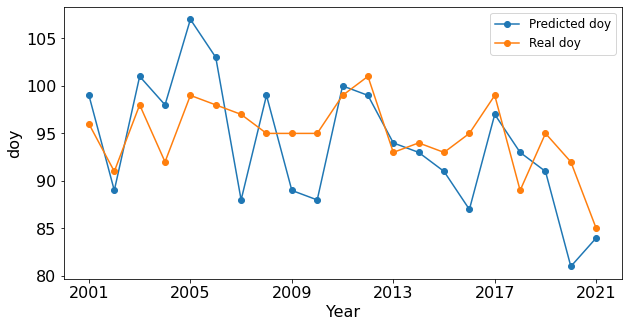

In [44]:
# plot the predict, real doy vs. year
start = 2001
end = 2021
result_pred_ts = predict_blooming_beta_ts(start, end)
x = np.arange(start, end + 1)

f = plt.figure(figsize=(10, 5))
plt.plot(x, result_pred_ts[0], 'o-', label = 'Predicted doy')
plt.plot(x, result_pred_ts[1], 'o-', label = 'Real doy')
plt.xlabel("Year", fontsize = 16)
plt.ylabel("doy", fontsize = 16)
# plt.ylim([67, 115])
plt.xticks(np.arange(2001, 2022, 4), fontsize = 16)
plt.yticks(fontsize = 16)
# plt.title("th = 0.5")
plt.legend(fontsize = 12, loc = 'upper right')
plt.show()
# f.savefig("../result_figures/washington_beta.png", bbox_inches='tight', dpi=1200)
# f.savefig("../result_figures/washington_beta_modified.png", bbox_inches='tight', dpi=1200)

In [38]:
np.array([np.average(train[train['year'] == y-1][-71:]['TAVG']) for y in range(2001, 2022)])

array([11.05352113,  9.94225352,  8.84507042, 11.36056338, 11.57042254,
        9.80492958, 11.39859155, 10.88591549, 10.64366197, 10.74647887,
       10.43943662, 11.07887324,  9.1971831 ,  9.95774648, 10.24084507,
       12.28169014, 11.0971831 ,  9.27605634, 11.52112676, 11.55352113,
       10.98507042])